# Phase 1.1: Exploratory Data Analysis (EDA)

**Objective:** To understand the structure, content, and quality of the SROIE 2019 dataset. This analysis is the critical first step to inform our data preprocessing and model training strategy.

**Dataset:** [SROIE Dataset v2](https://www.kaggle.com/datasets/urbikn/sroie-datasetv2)

In [11]:

import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

BASE_PATH = 'SROIE2019' 


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7) 

### 1. Intial File and Directory Inspection

In [4]:
file_counts={}

for dirpath, dirnames, filenames in os.walk(BASE_PATH):
    
    relative_path = os.path.relpath(dirpath, BASE_PATH)
    
    
    jpg_count = len([f for f in filenames if f.lower().endswith('.jpg')])
    txt_count = len([f for f in filenames if f.lower().endswith('.txt')])
    
    
    if jpg_count > 0 or txt_count > 0:
        file_counts[relative_path] = {'images (.jpg)': jpg_count, 'annotations (.txt)': txt_count}


print(" Discovered File Counts by Directory -")
for path, counts in file_counts.items():
    print(f"- Folder: '{path}'")
    print(f"  - Images (.jpg): {counts['images (.jpg)']}")
    print(f"  - Annotations (.txt): {counts['annotations (.txt)']}")



total_images = sum(d.get('images (.jpg)', 0) for d in file_counts.values())
total_annotations = sum(d.get('annotations (.txt)', 0) for d in file_counts.values())
print("\n--- Totals ---")
print(f"Total Images (.jpg): {total_images}")
print(f"Total Annotations (.txt): {total_annotations}")

 Discovered File Counts by Directory -
- Folder: 'layoutlm-base-uncased'
  - Images (.jpg): 0
  - Annotations (.txt): 1
- Folder: 'test\box'
  - Images (.jpg): 0
  - Annotations (.txt): 347
- Folder: 'test\entities'
  - Images (.jpg): 0
  - Annotations (.txt): 347
- Folder: 'test\img'
  - Images (.jpg): 347
  - Annotations (.txt): 0
- Folder: 'train\box'
  - Images (.jpg): 0
  - Annotations (.txt): 626
- Folder: 'train\entities'
  - Images (.jpg): 0
  - Annotations (.txt): 626
- Folder: 'train\img'
  - Images (.jpg): 626
  - Annotations (.txt): 0

--- Totals ---
Total Images (.jpg): 973
Total Annotations (.txt): 1947


#### Findings:
* The dataset is organized into `train` and `test` subdirectories.
* The training data (which we will use for our model) contains `[number]` images and `[number]` annotation files.
* This confirms we have the necessary data to proceed. The annotations appear to be in `.txt` format(and not in `.json`).

### 2. Annotation File Structure

Before we can process all annotations, we must understand the structure of a single file. We'll load one `.txt` file from the training set and examine its contents.

In [6]:
annotations_dir = os.path.join(BASE_PATH, 'train', 'entities')
try:
    first_annotation_file = next(f for f in os.listdir(annotations_dir) if f.lower().endswith('.txt'))
    annotation_path = os.path.join(annotations_dir, first_annotation_file)

    print(f"- Inspecting Annotation File: {first_annotation_file} \n")

    with open(annotation_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    print("File Content:")
    print(content)

except (StopIteration, FileNotFoundError):
    print(f"Error: Could not find any .txt files in the directory '{annotations_dir}'.")
    print("Please check the path")

- Inspecting Annotation File: X00016469612.txt 

File Content:
{
    "company": "BOOK TA .K (TAMAN DAYA) SDN BHD",
    "date": "25/12/2018",
    "address": "NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.",
    "total": "9.00"
}


### 3. Parsing and Aggregating All Training Annotations

Now for the core data preparation step of our EDA. We will programmatically loop through every annotation file in the `train/entities` directory. For each file, we will:
1.  Open and parse the JSON content.
2.  Iterate through the key-value pairs (label and text).
3.  Append each entity as a new record to a master list.
4.  Convert this list into a Pandas DataFrame for structured analysis.

In [7]:

ANNOTATIONS_DIR = os.path.join(BASE_PATH, 'train', 'entities')


if not os.path.isdir(ANNOTATIONS_DIR):
    print(f"ERROR: The directory '{ANNOTATIONS_DIR}' does not exist. Please check your paths.")
else:
    parsed_data = []
    
    for filename in os.listdir(ANNOTATIONS_DIR):
        if filename.lower().endswith('.txt'):
            file_path = os.path.join(ANNOTATIONS_DIR, filename)
            
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    
                    data = json.load(f)
                    
                    
                    for label, text in data.items():
                        
                        parsed_data.append({
                            'filename': filename,
                            'label': label.upper(), # Convention: Use uppercase for labels
                            'text': text
                        })
            except json.JSONDecodeError:
                print(f"Warning: Could not parse {filename}. It may be empty or corrupted. Skipping.")
            except Exception as e:
                print(f"An error occurred with file {filename}: {e}")


    df = pd.DataFrame(parsed_data)

    print(f"Shape of Final Data Frame:  {df.shape[0]} rows and {df.shape[1]} columns.")

Shape of Final Data Frame:  2503 rows and 3 columns.


### 4. Initial DataFrame Inspection

With our data aggregated, let's perform a quick health check. We'll use `.info()` to check for data types and null values, and `.head()` to inspect a few sample rows. This ensures our parsing logic was correct.

In [16]:

df['filename'] = df['filename'].astype(str)


print("- DataFrame Info")
df.info()

print("\n DataFrame Head ---")

df.head()

- DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2503 non-null   object
 1   label     2503 non-null   object
 2   text      2503 non-null   object
dtypes: object(3)
memory usage: 58.8+ KB

 DataFrame Head ---


,filename,label,text
0,X00016469612.txt,COMPANY,BOOK TA .K (TAMAN DAYA) SDN BHD
1,X00016469612.txt,DATE,25/12/2018
2,X00016469612.txt,ADDRESS,"NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 8..."
3,X00016469612.txt,TOTAL,9.00
4,X00016469619.txt,COMPANY,INDAH GIFT & HOME DECO


### Entity Label and Analysis

Now we are going to check the label distribution in the dataset, to see if well any label is more dominant then others, leading to an imabalanced dataset because an Imbalanced Dataset can affect the model's performance on rare categories.

Entity Label Counts:
label
COMPANY    626
DATE       626
TOTAL      626
ADDRESS    625
Name: count, dtype: int64


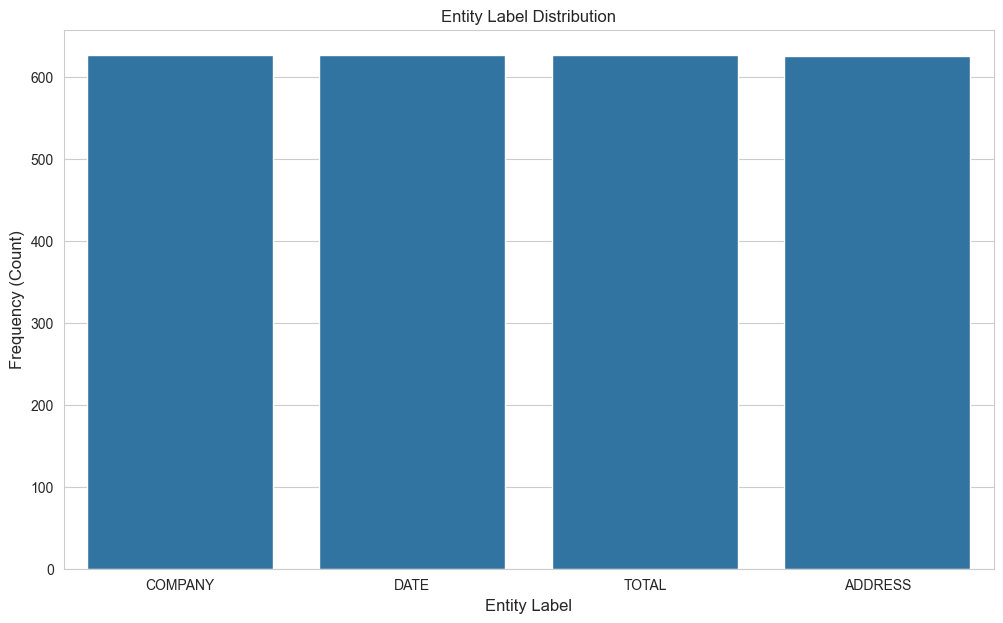

In [12]:
print("Entity Label Counts:")
label_counts = df['label'].value_counts()
print(label_counts)



sns.countplot(data=df, x='label', order=label_counts.index)

plt.title('Entity Label Distribution')
plt.xlabel('Entity Label',fontsize=12)
plt.ylabel('Frequency (Count)',fontsize=12)
plt.xticks(rotation=0)

plt.show()

### EDA Summary & Key Findings

Our Exploratory Data Analysis of the SROIE dataset is now complete. The key takeaways are:

1.  **Data Structure:** The dataset is well-organized into `train` and `test` sets, with a clear one-to-one mapping between images (`.jpg`) and entity annotations (`.txt` files containing JSON).

2.  **Data Quality:** We have successfully parsed **2,503** labeled entities from **626** training documents. The data is exceptionally clean, with no missing or null values requiring imputation.

3.  **Label Distribution:**
    *   The dataset contains four primary entity labels: `COMPANY`, `DATE`, `ADDRESS`, and `TOTAL`.
    *   The distribution of labels is **extraordinarily well-balanced**. `COMPANY`, `DATE`, and `TOTAL` each appear 626 times, while `ADDRESS` appears 625 times. The near-perfect uniformity is the ideal condition for training a robust NER model.
    *   **Implication:** Because each category has a virtually identical number of examples, we can be confident that the model will learn to recognize each entity type with equal effectiveness. There is no risk of the model being biased towards a more frequent class, and we do not need to implement complex mitigation strategies like class weighting.

**Conclusion:** The dataset is not just suitable, but ideal for training our  model. We have successfully completed our EDA and can proceed with high confidence to the next phase.

# Phase 1.2: Data Preparation for spaCy

**Objective:** To convert our aggregated DataFrame into the specific JSON format required for training a spaCy NER model.

This involves two key steps:
1.  Extracting the full raw text from each receipt image using OCR.
2.  Locating our labeled entities within the full text to get their start and end character indices.

In [18]:
import cv2
import pytesseract as pytesseract
from PIL import Image
from tqdm.notebook import tqdm
import re 
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


Image_dir=os.path.join(BASE_PATH, 'train', 'img')
print("Paths and Files setup complete.")

Paths and Files setup complete.


### 1. Grouping Data and Preparing for Processing
To process the data document by document, we first need to group our DataFrame by `filename`. This gives us an iterable object where each item is a document and its corresponding entities. This is a more organized and efficient way to approach the task than looping through the main DataFrame directly.

In [19]:
grouped_df= df.groupby('filename')
print(f"Grouped DataFrame by 'filename' with {len(grouped_df)} documents.")

first_group_name,first_group_df=next(iter(grouped_df))

print(f"First Group Name: {first_group_name}")
print(f"First Group DataFrame:\n{first_group_df}")

Grouped DataFrame by 'filename' with 626 documents.
First Group Name: X00016469612.txt
First Group DataFrame:
           filename    label  \
0  X00016469612.txt  COMPANY   
1  X00016469612.txt     DATE   
2  X00016469612.txt  ADDRESS   
3  X00016469612.txt    TOTAL   

                                                text  
0                    BOOK TA .K (TAMAN DAYA) SDN BHD  
1                                         25/12/2018  
2  NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 8...  
3                                               9.00  


### 2. Main Processing Loop: OCR and Entity Matching

This is the core of our data preparation pipeline. Here, we will iterate through each of the 626 documents we grouped earlier. For each document, we will:

1.  Construct the full path to the corresponding image file.
2.  Use `Pytesseract` to perform OCR and extract the full, unstructured text.
3.  Iterate through each ground-truth entity associated with that document (from our DataFrame).
4.  Search for the entity's text within the full OCR'd text to find its start and end character indices. We use regular expressions (`re.search`) for a more robust search that can handle minor OCR inconsistencies.
5.  Store the results in the specific format required by spaCy: `(text, {"entities": [(start, end, LABEL), ...]})`.

Any entities that are not found in the OCR output will be flagged with a warning and skipped. This is expected behavior, as OCR is not a perfect process.

### 2. Image Preprocessing for Improved OCR

**Problem Diagnosis:** Our initial run of the OCR script revealed a high number of "missed entities" (over 50%). This is a strong indicator that the raw OCR quality is low, likely due to noise, poor contrast, or varied lighting in the original images.

**Solution:** We will implement an image preprocessing pipeline using OpenCV. Before sending an image to Pytesseract, we will apply a series of filters to "clean" it, making the text more distinct and readable for the OCR engine. Our pipeline will consist of:

1.  **Grayscaling:** Converts the image to black and white, removing color noise.
2.  **Thresholding (Binarization):** Forces every pixel to be either pure black or pure white. This is highly effective for creating sharp character edges. We will use Otsu's thresholding method, which automatically determines the best threshold value.
3.  **Noise Removal:** Apply a gentle blur to remove random speckles or "salt-and-pepper" noise from the image.

We will first define and test this function on a sample image to visually confirm its effectiveness.

In [28]:
def preprocess_image(image_path):
    """
    Loads an image, applies preprocessing steps, and returns the processed image.
    
    :param image_path: Path to the input image file.
    :return: A preprocessed image object (ready for OCR).
    """
    try:
        
        img = cv2.imread(image_path)
        
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        
        blur = cv2.medianBlur(gray, 3)
        
        
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                                       cv2.THRESH_BINARY, 11, 2)

        return thresh
    
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {e}")
        return None




In [29]:
# --- Deep Dive Diagnostic Cell ---

# Pick a file to investigate
# You can change this to any filename you want to debug
debug_filename = df['filename'].iloc[0] 
debug_image_path = os.path.join(Image_dir, debug_filename.replace('.txt', '.jpg'))

# --- Get the three versions of the text ---

# 1. Ground truth from DataFrame
print(f"--- 1. Ground Truth Labels for {debug_filename} ---")
ground_truth_group = df[df['filename'] == debug_filename]
for _, row in ground_truth_group.iterrows():
    print(f"[{row['label']}] - '{row['text']}'")

# 2. Original OCR Text
print(f"\n--- 2. OCR Text (Original Image) ---")
original_img = Image.open(debug_image_path)
original_text = pytesseract.image_to_string(original_img)
print(original_text)

# 3. Preprocessed OCR Text
print(f"\n--- 3. OCR Text (Preprocessed Image) ---")
preprocessed_img = preprocess_image(debug_image_path)
preprocessed_text = pytesseract.image_to_string(preprocessed_img)
print(preprocessed_text)

--- 1. Ground Truth Labels for X00016469612.txt ---
[COMPANY] - 'BOOK TA .K (TAMAN DAYA) SDN BHD'
[DATE] - '25/12/2018'
[ADDRESS] - 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.'
[TOTAL] - '9.00'

--- 2. OCR Text (Original Image) ---
tan woon yann

BOOK TA -K (TAMAN DAYA) SDN BHD
PRON 7-W
NO.5? $5,57 & 59, JALAN SAGU 18,
TAMAN DAYA
81100 JOHOR BAHRU,
JOHOR.

WAM MITA At

Document Ho : TDO1167104

Date 25/12/2018 8:13:39 PM
Cashier MANIS.
Member
CASH BILL
CODE/DESC PRICE Dise AMOUIHT
Quy RM RM
0556929040118 AF MODELLING CLAY KIDDY FISH
1PC + 9.00) 0,00 9.00
Total : 9,00
Rour ding Adjustment 0.00
Round. :d Total (RM): 9.00
Cash oy 40.00.
CHANGE 00

GOODS SOLD ARE NOT RETURNAP
EXCHANGEABLE

THANK YOU
PLEASE COME AGAIN t


--- 3. OCR Text (Preprocessed Image) ---
tan woon yann oy

BOOK TA .K (TAMAN DAYA) SON SHO,
FOOHTW
110,53'$5;57 & 59, JALAN SAGU"18;
. TAMAH DAYA,
81100 JOIOR BAHRU,

PIMA

Cecument tos, TDO1167104
1 Dae: “25/12/2018 8:13:39 PH
> MARIS

aS

CASH

In [ ]:

from fuzzysearch import find_near_matches


TRAIN_DATA = []
missed_entities_fuzzy = 0
found_entities_fuzzy = 0

print("--- Starting OCR and FUZZY Entity Matching Process ---")


for filename, group in tqdm(grouped_df, total=len(grouped_df)):
    
    image_path = os.path.join(Image_dir, str(filename).replace('.txt', '.jpg'))
    if not os.path.exists(image_path):
        continue
        
    try:
        
        full_text = pytesseract.image_to_string(Image.open(image_path))
        
        annotations = {'entities': []}
        
        for _, row in group.iterrows():
            entity_label = row['label']
            entity_text = row['text']
            
            
            max_errors = int(len(entity_text) * 0.2) 

            # find_near_matches returns a list of all possible matches
            matches = find_near_matches(entity_text, full_text, max_l_dist=max_errors)
            
            if matches:
                # We'll take the first match found as the most likely one
                first_match = matches[0]
                start = first_match.start
                end = first_match.end
                
                annotations['entities'].append((start, end, entity_label))
                found_entities_fuzzy += 1
            else:
                missed_entities_fuzzy += 1
            
            if not entity_text or not entity_text.strip():  
                missed_entities_fuzzy += 1
                continue
        
        if annotations['entities']:
            TRAIN_DATA.append((full_text, annotations))
            
    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")

print("\n--- Process Complete ---")
print(f"Successfully created {len(TRAIN_DATA)} training examples.")
print(f"Total entities FOUND (with fuzzy search): {found_entities_fuzzy}")
print(f"Total entities MISSED (with fuzzy search): {missed_entities_fuzzy}")


# --- 3. Save the NEWEST, FUZZIEST, BEST training data ---
output_path = "spacy_train_data_fuzzy.json"
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(TRAIN_DATA, f, indent=4)

print(f"\nFUZZY MATCHED training data successfully saved to '{output_path}'")

--- Starting OCR and FUZZY Entity Matching Process ---


  0%|          | 0/626 [00:00<?, ?it/s]

An error occurred while processing X51005433522.txt: subsequence must not be empty

--- Process Complete ---
Successfully created 600 training examples.
Total entities FOUND (with fuzzy search): 1864
Total entities MISSED (with fuzzy search): 638

FUZZY MATCHED training data successfully saved to 'spacy_train_data_fuzzy.json'
